# Assignment II: Exploring Why Civil Resistance Works

---

>Konstantinos Kyrkos <br>
>Registration Number p3351907 <br>
>kkyrkos@aueb.gr

This notebook provides my solutions for the second assignment for the Practical Data Science class at Data Science MSc at AUEB. <br>
Bollow you will find the solution to all 7 exercises. <br>
The only prerequisite for running the commands below is to provide the already given WCRWreplication.dta file which contains the data to which the assignment is related to.

## 1: Frequency of Nonviolent and Violent Campaign End Years


In [57]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics as sgr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from statsmodels.stats.outliers_influence import summary_table
import math

%matplotlib inline

In [3]:
data = pd.read_stata("WCRWreplication.dta")

print(data.head(5))

   defect  outcome  peakmembership  eyear  byear            location  \
0     1.0        5         50000.0   1959   1956                Cuba   
1     0.0        3          5000.0   1920   1918               Haiti   
2     1.0        5         30000.0   1985   1985               Haiti   
3     0.0        3           650.0   1924   1916  Dominican Republic   
4     1.0        3             NaN   1965   1965  Dominican Republic   

               campaign                target  lccode  tccode  ...   lmtnest  \
0      Cuban Revolution        Batista regime    40.0    40.0  ...  1.694107   
1           Caco Revolt       U.S. occupation    41.0     2.0  ...       NaN   
2                        Jean Claude Duvalier    41.0    41.0  ...  2.797281   
3  Dominican insurgency       U.S. occupation    42.0     2.0  ...       NaN   
4              leftists       Loyalist regime    42.0    42.0  ...  2.856470   

       ef  loclpolity1  loclcap1  loclcap2  loclcap3  loclcap4     mempc  \
0  0.2134 

We want to visualize the frequency of nonviolent and violent campaigns. <br> 
The frequency of the campaigns should be counted based on their end years, at decades. Also we want the violent and nonviolent campaign counts to be stacked on each other. <br>
For that we start by getting our data to the form we want. <br>

In [4]:
years = data.groupby(data.eyear // 10 * 10).count().eyear
eyears = years.index

non_violent = data[data.nonviol==1].groupby(data.eyear // 10 * 10).count().eyear
non_violent[1900]=0
non_violent.sort_index(inplace=True)

violent = data[data.viol==1].groupby(data.eyear // 10 * 10).count().eyear

Now that we have our data in the preferred form, we simply draw a stackplot to present our data.

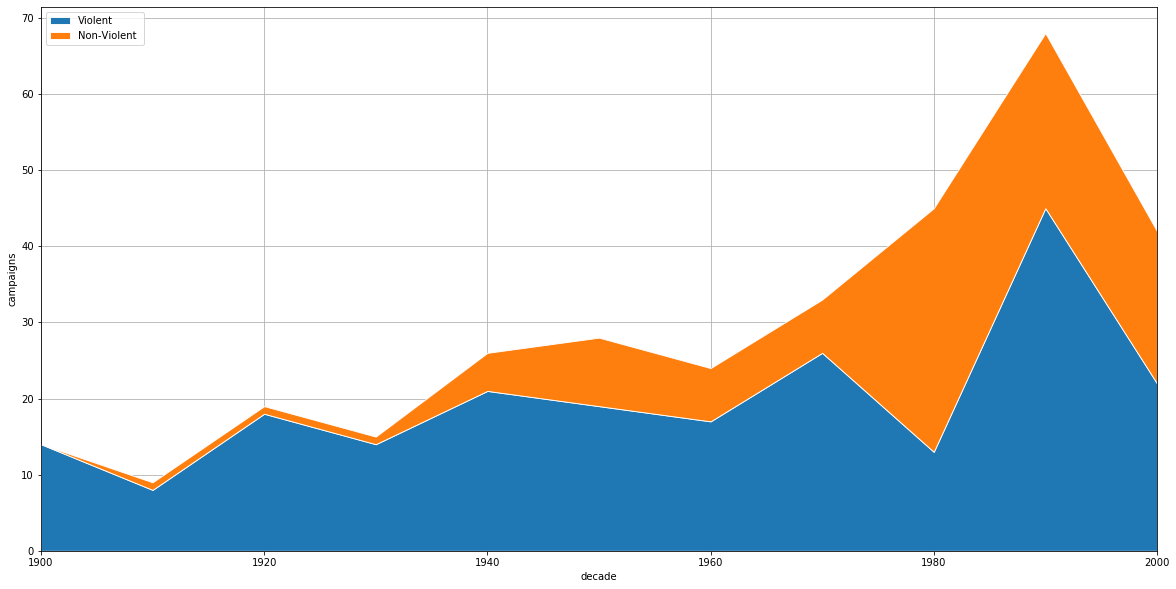

In [5]:
labels = [ "Violent","Non-Violent "]

fig, ax = plt.subplots()
ax.grid(True)
ax.stackplot(eyears, violent, non_violent, labels=labels, edgecolors='white', linewidths=.9, )
ax.set_axisbelow(True)
plt.xlabel('decade')
plt.ylabel('campaigns')
plt.margins(x=0)
plt.legend(loc="upper left")
fig = plt.gcf()
fig.set_size_inches(20,10, forward = False)
plt.show()

## 2: Number of Nonviolent Campaigns and Percentage of Success

At this point we want to create a plot showing, for each decade from 1940 onwards, the number of nonviolent campaigns and the percentage of success. Our plot will have two vertical axes, one for each of the metrics. <br>
First we have to manipulate our data in order to prepare them for our plot.

In [6]:
non_violent_from_40s = data[data.nonviol==1].groupby(data.eyear // 10 * 10).count().eyear[3:]

successful = data[(data.nonviol==1) & (data.success==1)].groupby(data.eyear // 10 * 10).count().eyear[2:]

success_perc = successful / non_violent_from_40s

Next, we draw our plot with the data we have gathered.

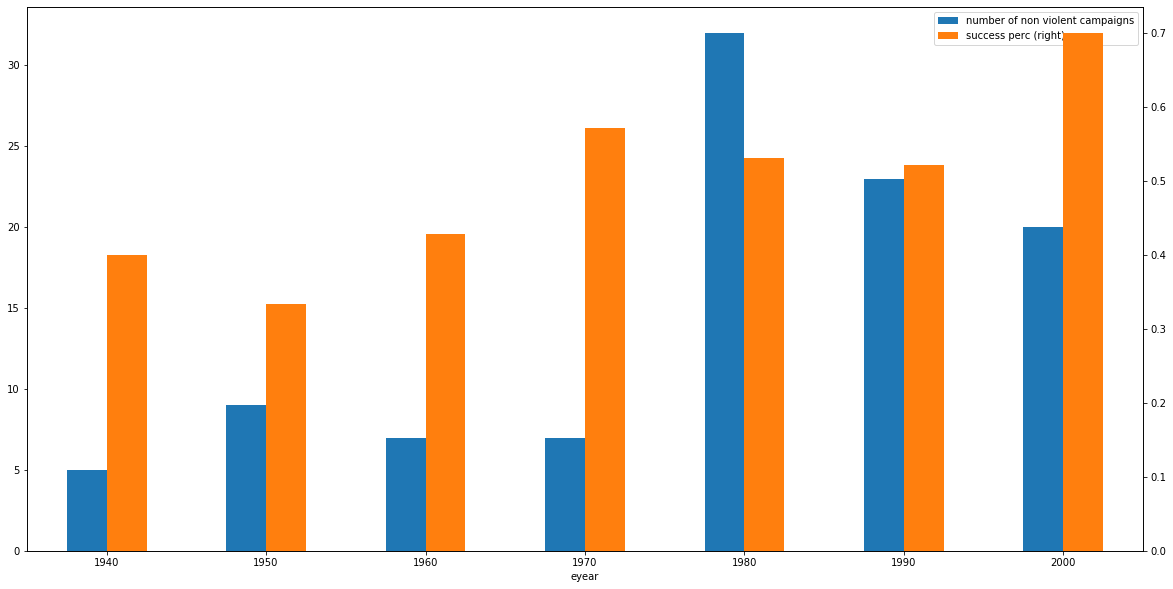

In [7]:
success_df = pd.DataFrame({'number of non violent campaigns':non_violent_from_40s, 'success perc':success_perc})
success_df.plot(kind= 'bar' , secondary_y= 'success perc' , rot= 0 , figsize=(20, 10))

plt.show()

## 3: Success Rate by Decade

For this exercise we want to create a plot showing the success rate for violent and nonviolent campaigns by decade. <br> 
Our plot should show that nonviolent campaigns have higher success probabilities like the book of well-received book of Erica Chenoweth ("Why Civil Resistance Works") suggests.

First again we start by preparing our data for the plot which will come later.

In [8]:
non_violent_from_40s = data[data.nonviol==1].groupby(data.eyear // 10 * 10).count().eyear[3:]

nonviol_successful = data[(data.nonviol==1) & (data.success==1)].groupby(data.eyear // 10 * 10).count().eyear[2:]

nonviol_success_perc = nonviol_successful / non_violent_from_40s

violent_from_40s = data[data.viol==1].groupby(data.eyear // 10 * 10).count().eyear[4:]

viol_successful = data[(data.viol==1) & (data.success==1)].groupby(data.eyear // 10 * 10).count().eyear[4:]

viol_success_perc = viol_successful / violent_from_40s

years = data.groupby(data.eyear // 10 * 10).count().eyear
eyears = years.index[4:]

Now that we have our data ready for plot, we can present our results.

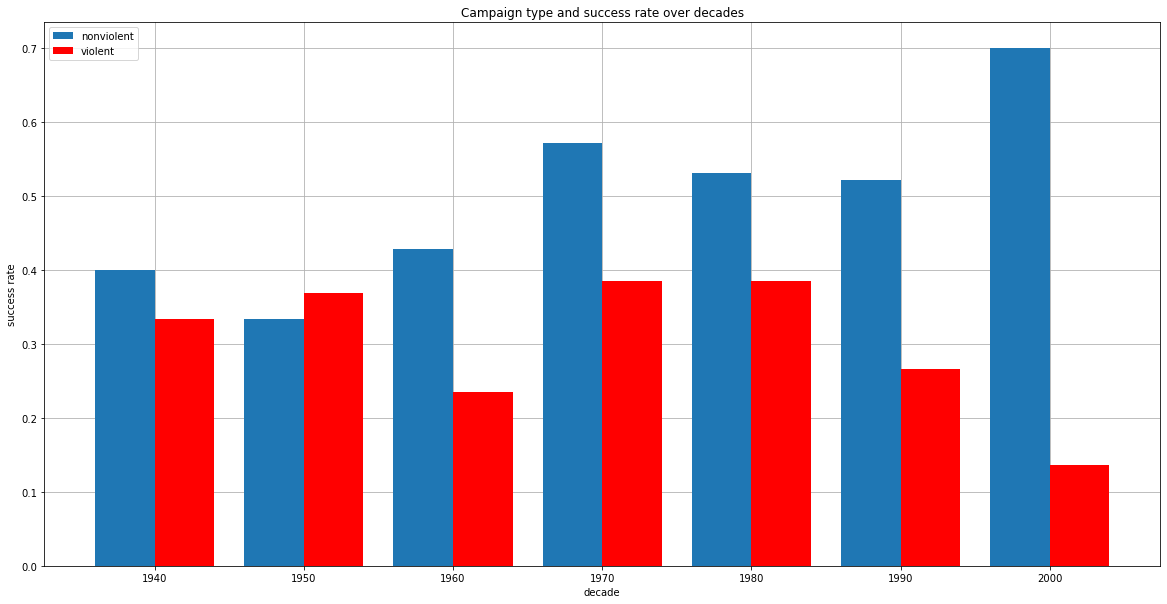

In [9]:
fig = plt.figure()
ax = fig.add_subplot() 
ax.set_axisbelow(True)
N = len(eyears)
ind = np.arange(N) 
width = 0.4     
plt.grid(True)
plt.bar(ind, nonviol_success_perc, width, label='nonviolent')
plt.bar(ind + width, viol_success_perc, width, label='violent', color = 'red')
plt.xlabel('decade')
plt.ylabel('success rate')
plt.title('Campaign type and success rate over decades')
fig = plt.gcf()
fig.set_size_inches(20,10, forward = False)
plt.xticks(ind + width / 2, eyears)
plt.legend(loc='upper left')
plt.show()

## 4. Twenty-Five Largest Resistance Campaigns, 1900-2006

For this exercise we want to create a table with the twenty-five largest resistance campaigns, for all years, based on their number of members at the highest point (peak membership). <br>
The table will include the membership, the start year, the end year, the location, the target, whether it was violent or not, and whether it was successful or not. <br>
Finally we will try to check if we can notice anything about Greece.

We start by collecting and sorting our data.

In [11]:
data_ordered_by_membership = data.sort_values(by=['peakmembership'],ascending=False).head(25).reset_index()

Next we choose the preferred columns and make our new table more readable/presentable removing duplicate columns.

In [12]:
largest_campaigns = data_ordered_by_membership[['peakmembership','byear','eyear','location','target',
                                                'viol', 'nonviol', 'success', 'failure']]
largest_campaigns['violent'] = np.where(largest_campaigns.viol==1,'yes','no')
largest_campaigns['successful'] = np.where(largest_campaigns.success==1,'yes','no')
del largest_campaigns['viol']
del largest_campaigns['nonviol']
del largest_campaigns['success']
del largest_campaigns['failure']
print(largest_campaigns)

    peakmembership  byear  eyear        location               target violent  \
0        4500000.0   1937   1945           China  Japanese occupation     yes   
1        2000000.0   1977   1979            Iran    Shah Reza Pahlavi      no   
2        2000000.0   1986   1983     Philippines     Ferdinand Marcos      no   
3        1000000.0   1988   1988           Burma       military junta      no   
4        1000000.0   1989   1989           China     Communist regime      no   
5        1000000.0   1967   1968           China         anti-Maoists     yes   
6        1000000.0   1922   1949           China    Kuomintang regime     yes   
7        1000000.0   2006   2006          Mexico      Calderon regime      no   
8        1000000.0   2005   2005         Lebanon        Syrian forces      no   
9        1000000.0   1993   1999         Nigeria        Military rule      no   
10       1000000.0   1984   1985          Brazil        Military rule      no   
11        700000.0   1990   

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


After we have presented our data, we check if we can find anything about Greece and we do in the 17th row from above. <br>
We print this row again in order to comment on the data we found.

In [13]:
print(largest_campaigns.loc[16])

peakmembership               500000
byear                          1963
eyear                          1963
location                     Greece
target            Karamanlis regime
violent                          no
successful                      yes
Name: 16, dtype: object


We can see that there is an entry for Greece for the events that occurred in 1963. <br>
The campaign happened at the day of the funeral of G. Lambrakis. <br>
Lambrakis being a peacemaker of his time and a member of the left wing party was killed by members of the shadow government at the time when K. Karamanlis was the prime minister of Greece, ruling with excessive use of violence. <br>
This event led the people to indignation and made them want a fresh start, ending Karamanlis's authoritarian government. <br>
In other words, this nonviolent campaign which unfortunately started from a tragic death of a person, ended succeeding its cause.

## 5. The Effect of Participation on the Probability of Campaign Success

For the purpose of this exercise we want to examine the effect of participation on the probability of campaign success. 
We will run a logistic regression for success on membership per capita, controlling for the location’s logged population the year the campaign ends. <br>
After running the logistic regression we will explain our results. <br>
Having done that we will create a scatter plot showing the logged participants per capita, on the $x$ axis, and the probability of success, on the $y$ axis.

First we prepare our data and run the logistic regression for success on membership per capita, controlling for the location's logged population the year the campaign ends.

In [14]:
from statsmodels.formula.api import logit

success_mod = logit("success ~ mempc + lnpop", data).fit()

print(success_mod.summary())
print(success_mod.conf_int())

Optimization terminated successfully.
         Current function value: 0.594790
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                success   No. Observations:                  163
Model:                          Logit   Df Residuals:                      160
Method:                           MLE   Df Model:                            2
Date:                Sun, 01 Dec 2019   Pseudo R-squ.:                  0.1294
Time:                        11:20:59   Log-Likelihood:                -96.951
converged:                       True   LL-Null:                       -111.35
Covariance Type:            nonrobust   LLR p-value:                 5.551e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.8199      1.921     -3.030      0.002      -9.584      -2.055
mempc          4.4892      0.

Explaining and interpreting our results from above we can see the following. <br>
<ul>
  <li>The Pseudo R-squared value of 0.129 is fairly low. This is only logical due to the fact that we only used two of our many variables to express/predict the value of the success variable and so we have only expressed only 10% of the success variable.</li>
  <li>Each one-unit change in mempc will increase the log odds of getting success by 4.4892</li>  
  <li>Each one-unit change in lnpop will increase the log odds of getting success by 0.0907</li>  
  <li>The intercept is the log odds of having success when all the independent variables are held at zero; that is  $e^{-5.8199} \approx 0.0029679$. That means that $p / (1-p) = 0.0029679$</li>
   <li>It is also interesting to observe that the P-value of mempc is really low (almost zero) meaning that this variable is really significant for all levels of significance</li>
</ul>

Now we create a scatter plot showing the logged participants per capita, on the $x$ axis, and the probability of success, on the $y$ axis.

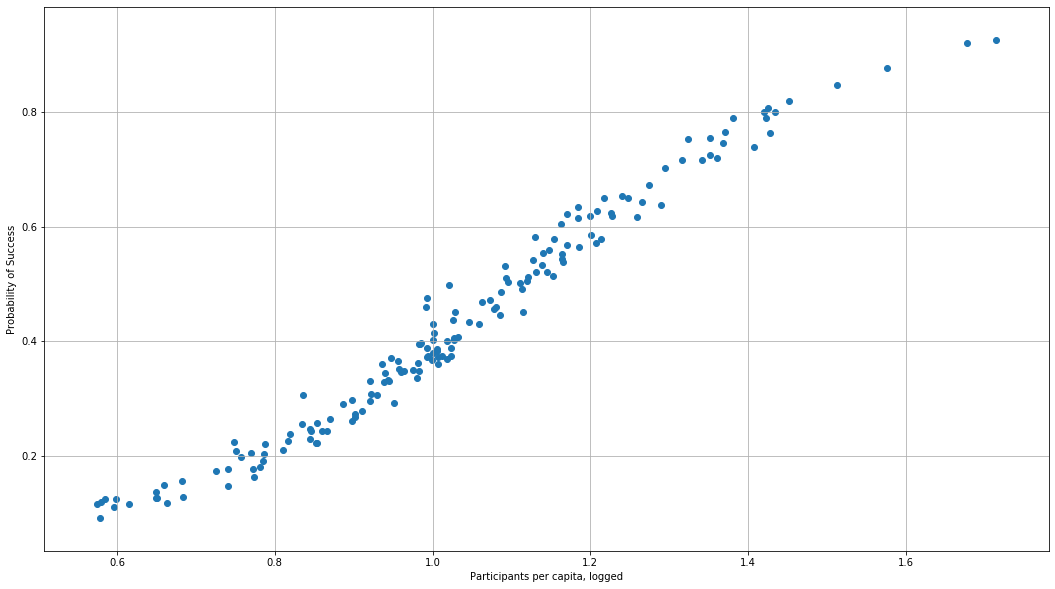

In [15]:
plt.scatter(data.mempc, success_mod.predict(data))
plt.xlabel('Participants per capita, logged')
plt.ylabel('Probability of Success')
plt.grid()
plt.rc('axes', axisbelow=True)
fig = plt.gcf()
fig.set_size_inches(18,10, forward = False)
plt.show()

## 6. The Level of Participation Tipping Point

For this exercise we want to use the results we obtained in the previous question, to find the percentage of the population that is the tipping point for success in a campaign.
We start by collecting the data we need and sorting them to see our results. <br>
First we start by setting up again the data we will use for this exercise.

In [16]:
success_fit = logit("success ~ mempc + lnpop", data).fit()
predicted_success = success_fit.predict(data)
print(success_mod.summary())
print(success_mod.conf_int())

Optimization terminated successfully.
         Current function value: 0.594790
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                success   No. Observations:                  163
Model:                          Logit   Df Residuals:                      160
Method:                           MLE   Df Model:                            2
Date:                Sun, 01 Dec 2019   Pseudo R-squ.:                  0.1294
Time:                        11:21:04   Log-Likelihood:                -96.951
converged:                       True   LL-Null:                       -111.35
Covariance Type:            nonrobust   LLR p-value:                 5.551e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.8199      1.921     -3.030      0.002      -9.584      -2.055
mempc          4.4892      0.

The first approach we try is also the simplest and we do it by creating a new dataframe with the predicted data, along with the data from the variables we used to make predictions. <br>
Keeping only the values which correspond to success over 0.49 we should get the tipping point for success in a campaign. <br>
Since our data are logged, we use exp to de-log them and then do the math to get our population percentage.

In [89]:
values = pd.DataFrame({'mempc':data.mempc, 'lnpop':data.lnpop, 'lmembers':data.lmembers, 'success':predicted_success})
values = values[values.success>=0.49]
values = values.sort_values(by='mempc',ascending=True)
print(values.head())
perc = np.exp( values.lmembers.tolist() ) / np.exp( values.lnpop.tolist() )
perc.sort()
print(perc[0], "corresponds to success: ",values.iloc[0].success)
print(perc[1], "corresponds to success: ",values.iloc[1].success)


        mempc      lnpop   lmembers   success
262  1.020733  13.534897  13.815511  0.497576
140  1.091469  11.554644  12.611538  0.532006
269  1.092927  10.534025  11.512925  0.510537
299  1.096068  10.037786  11.002100  0.502808
216  1.110516   9.283026  10.308952  0.501905
1.3239423300881805 corresponds to success:  0.4975759966393706
2.622986376685759 corresponds to success:  0.5320059497025783


As we can see from the values above, there is a clear gap in our success values and so we cannot give a clear border for our tipping point. Nevertheless we can give an interval in which the tipping point of success happens. That interval located around 1.32 and 2.62 of the population.

Another way of looking at our problem is forming an equation from the coefficients we found. Then the tipping point would be the line of our equation. So we form our equation from the data we can find in the summary above.<br>
We want sigmoid(4.4892 * mempc + 0.0907 * lnpop  -5.8199) >=0.5. We added a virtual sigmoid function because although we have our coefficients, the final line would follow a sigmoid shape as we know from the theory of logistic regression. <br>
So the tipping point is exactly this line and so we can transform the inequality to an equality and so we have <br> sigmoid(4.4892 * mempc + 0.0907 * lnpop  -5.8199) = 0.5. <br>
We know that mempc = lmembers/lnpop and also we have to raise all values to exponential in order to remove the log from our variables.<br>
sigmoid(4.4892 * (lmembers/lnpop) + 0.0907 * lnpop  -5.8199) = 0.5. <br>
This line expressed by the two varibles (lmembers, lnpop) described the border on which we get values of 0.5 and any value above this line gives us the desired outcome of over 0.5.

## 7. Nonviolent Resistance, Target Regime Type, Geographical Location

1. We want to examine whether nonviolent resistance remains significant even if we control for the regime type. <br>
So we run a logistic regression of success on the nonviolence indicator controlling for the POLITY IV score of campaign target, the log of peakmembership, and the location’s logged population the year the campaign ends.

In [43]:
success_mod = logit("success ~ nonviol + tpolity + lmembers + lnpop", data).fit()

print(success_mod.summary())
print(success_mod.conf_int())

Optimization terminated successfully.
         Current function value: 0.567143
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                success   No. Observations:                  141
Model:                          Logit   Df Residuals:                      136
Method:                           MLE   Df Model:                            4
Date:                Sat, 30 Nov 2019   Pseudo R-squ.:                  0.1627
Time:                        17:26:02   Log-Likelihood:                -79.967
converged:                       True   LL-Null:                       -95.506
Covariance Type:            nonrobust   LLR p-value:                 2.953e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1085      1.413     -0.077      0.939      -2.878       2.661
nonviol        0.9048      0.

Explaining and interpreting our results from above we can see the following. <br>
<ul>
  <li>The Pseudo R-squared value of 0.162 is again fairly low. This is only logical due to the fact that we only used a few of our many variables to express/predict the value of the success variable and so we have only expressed only about 15% of the success variable.</li>
  <li>Each one-unit change in nonviol will increase the log odds of getting success by 0.9048</li>  
  <li>Each one-unit change in tpolity  will increase the log odds of getting success by 0.0520</li>  
  <li>Each one-unit change in lmembers will increase the log odds of getting success by 0.3751</li>  
  <li>Each one-unit change in lnpop will decrease the log odds of getting success by -0.4363</li>  
  <li>The intercept is the log odds of having success when all the independent variables are held at zero; that is $e^{-0.1085}$</li> <br>
 Commenting on the significance of variables we observe the following:
  <li>Almost all variables have p-values below 0.05 and all of them have values below 0.1. That means that all of them are considered significant for a significance level of 0.1 and the majority of them for significance a level of 0.05</li>
So finally we can say that nonviolent resistance remains significant even if we control for the regime type
</ul>

2. We also want to examine whether nonviolent resistance remains significant even if we control for geographical location of the campaign. <br>
So we run a logistic regression of success on the nonviolence indicator controlling for the geographical location of the campaign. <br>
We leave randomly one variable describing the location out of the regression. We do this because, since we have 6 variables and each describes a region, having all the others except one, the outcome for this region will be expressed as what's left from all the others and so there is no use of adding this variable too.

In [44]:
success_mod = logit("success ~ nonviol + americas + asia + africa + europe + fsu", data).fit()

print(success_mod.summary())
print(success_mod.conf_int())

Optimization terminated successfully.
         Current function value: 0.591713
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                success   No. Observations:                  323
Model:                          Logit   Df Residuals:                      316
Method:                           MLE   Df Model:                            6
Date:                Sat, 30 Nov 2019   Pseudo R-squ.:                 0.08320
Time:                        17:40:45   Log-Likelihood:                -191.12
converged:                       True   LL-Null:                       -208.47
Covariance Type:            nonrobust   LLR p-value:                 4.950e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7374      0.430     -4.042      0.000      -2.580      -0.895
nonviol        1.2582      0.

Explaining and interpreting our results from above we can see the following. <br>
<ul>
  <li>The Pseudo R-squared value of 0.0832 is again fairly low. This is again logical due to the fact that we only used the variables of the geographical location to express/predict the value of the success variable and so we have only expressed only the 1% of the success variable.</li>
  <li>Each one-unit change in nonviol will increase the log odds of getting success by 1.2582</li>  
  <li>Each one-unit change in americas will increase the log odds of getting success by 1.0604</li>  
  <li>Each one-unit change in asia will increase the log odds of getting success by 0.2612</li>  
  <li>Each one-unit change in africa will increase the log odds of getting success by 1.0235</li>  
  <li>Each one-unit change in europe will increase the log odds of getting success by europe</li>  
  <li>Each one-unit change in fsu will increase the log odds of getting success by 0.7645</li>  
  <li>The intercept is the log odds of having success when all the independent variables are held at zero; that is  $e^{-1.7374}$</li>
  Commenting on the significance of variables we observe the following:
  <li>The nonviol variable again is really significant on all levels of significance with value under 0.001 and almost near to zero.</li>
So finally we can say that nonviolent resistance remains significant even if we control the geographical location of the campaign.
</ul>